# Senadores - EDA e modelo produção parlamentar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))
import janitor

import datetime

import sqlite3 as sql

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

#nomalizing data to its std (x_new= x/std(x))
from scipy.cluster.vq import whiten

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## EDA Básico

In [2]:
!ls ../../dados/sql

base_completa_2020_09_10.db  base_completa.db  Normalização_03.ipynb


In [3]:
#Dados de parlamentares
con = sql.connect("../../dados/sql/base_completa.db")
df_sen=pd.read_sql("select * from senadores_cadastro",con)
df_sen_prop=pd.read_sql("select * from senadores_propostas",con)
df_sen_sess=pd.read_sql("select * from senadores_sessoes",con)
df_sen_voto=pd.read_sql("select * from senadores_votacoes",con)
df_diap=pd.read_sql("select * from diap",con)
con.close()

In [4]:
#df_sen.info()
#df_diap.info()

In [6]:
df_sen.drop(columns=["NM_CANDIDATO","NM_MUNICIPIO_NASCIMENTO","SQ_CANDIDATO",
                           "IDADE","NM_EMAIL","URL_SENADO","FOTO_URI","URL_PARTICULAR"], inplace=True)

In [7]:
#df_sen.sample(5)

In [8]:
#df_sen_prop.shape
#df_sen_prop.info()
#df_sen_prop.head()

## Percentual de cada tipo de proposta

In [9]:
df_prop_tipos=pd.DataFrame(df_sen_prop["TIPO_DESC"].value_counts())
df_prop_tipos.rename(columns={"TIPO_DESC":"QUANT"}, inplace=True)
df_prop_tipos.index.name="TIPO_DESC"
#df_prop_tipos

In [10]:
f = lambda x: x/x.sum()
df_prop_tipos["PERC"]=df_prop_tipos.apply(f)
#df_prop_tipos["QUANT"].plot(kind="bar")

## Sessões parlamentares com votacção

In [11]:
df_sen_sess["SESSAO_DATA"]=df_sen_sess["SESSAO_DATA"].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
#df_sen_sess.info()

In [13]:
# Ajusta colunas e nomes
df_sen_sess=df_sen_sess[["SESSAO_DATA","SESSAO","SESSAO_TIPO","SESSAO_DESCRICAO"]]
df_sen_sess.rename({"SESSAO_DESCRICAO":"SESSAO_DESC"}, axis=1, inplace=True)
#df_sen_sess.tail()

In [14]:
#df_sen_sess[df_sen_sess["SESSAO"]==86315]

In [15]:
df_sen_voto["SESSAO"]=df_sen_voto["SESSAO"].astype("object")
df_sen_sess["SESSAO"]=df_sen_sess["SESSAO"].astype("object")
#df_sen_voto.info()
#df_sen_sess.info()
                                        

In [16]:
#sessao=df_sen_voto["SESSAO"]=="192306"
#senador=df_sen_voto["ID_SENADO"]=="1023"
#df_sen_voto[(sessao & senador)]

## Percentual de cada tipo de sessão

In [17]:
#df_sen_sess.info()
#df_sen_sess["SESSAO_DESC"].value_counts()
df_sess_tipos=pd.DataFrame(df_sen_sess["SESSAO_DESC"].value_counts())
df_sess_tipos

,SESSAO_DESC
Sessão Deliberativa Ordinária,224
Sessão Deliberativa Remota,182
Sessão Deliberativa Extraordinária,9


In [18]:
df_sess_tipos.rename(columns={"SESSAO_DESC":"QUANT"}, inplace=True)
df_sess_tipos.index.name="TIPO_DESC"
#df_sess_tipos

In [19]:
f = lambda x: x/x.sum()
df_sess_tipos["PERC"]=df_sess_tipos.apply(f)
#df_sess_tipos["QUANT"].plot(kind="bar")

In [20]:
#df_sen_sess.info()
#df_sen_voto.info()

## Para cada senador

### Total de propostas

In [21]:
x=df_sen_prop.groupby("ID_SENADO")["TIPO"].value_counts()
df_sen_prop_tipos=x.unstack().fillna(0)
df_sen_prop_tipos["PROP_TOTAL"]=df_sen_prop_tipos.sum(axis=1)

df_sen_prop_tipos.sort_values("PROP_TOTAL", inplace=True, ascending=False)
#df_sen_prop_tipos.head()
#df_sen_prop_tipos["PROP_TOTAL"].iloc[1:10].plot(kind="bar")

In [22]:
df_sen_prop_tipos=df_sen_prop_tipos[["REQ","PEC","PL","PROP_TOTAL"]]

In [23]:
df_sen_prod=pd.merge(df_sen,df_sen_prop_tipos, how="left", on="ID_SENADO")
#df_sen_prod.info()

### Total de votações

In [24]:
x=df_sen_voto.groupby("ID_SENADO")["VOTO"].value_counts()
#type(x)
df_sen_voto_tipos=x.unstack().fillna(0)
df_sen_voto_tipos["VOTO_TOTAL"]=df_sen_voto_tipos.sum(axis=1)
df_sen_voto_tipos=df_sen_voto_tipos.sort_values("NCom", ascending=False)
#df_sen_voto_tipos["NCom"].iloc[1:10].plot(kind="bar")
df_sen_voto_tipos["AUSENCIA"]=df_sen_voto_tipos["NCom"]/df_sen_voto_tipos["VOTO_TOTAL"]
df_sen_voto_tipos["PRESENCA"]=1-df_sen_voto_tipos["AUSENCIA"]
#df_sen_voto_tipos.head()

In [25]:
df_sen_assid=df_sen_voto_tipos[["PRESENCA","AUSENCIA"]]

In [26]:
df_sen_prod=pd.merge(df_sen_prod,df_sen_assid, how="left", on="ID_SENADO")
#df_sen_prod.info()

In [27]:
df=pd.merge(df_sen_prod,df_diap, how="left", on="CPF")
#df=df_sen_prod

In [28]:
#df.info()
df.fillna(0, inplace=True)

In [29]:
hoje=datetime.datetime.now()
df["IDADE"]=df["DT_NASCIMENTO"].apply(lambda x:(hoje-datetime.datetime.strptime(x, '%d/%m/%Y')).days//(365.25))

In [30]:
#df.sample(5)

In [31]:
#df.columns

In [32]:
#df.columns
df.drop(columns="DS_CARGO", axis=1, inplace=True)

In [33]:
#df.shape
#df.info()
#df.sample(10)

In [34]:
#df.info()
#df.describe().round(2)

In [35]:
#df.fillna(0, inplace=True)
#df.info()

In [36]:
#df.describe(include=np.object)

In [37]:
#df.info()
#unicos=df.nunique()
#unicos

## Defindo variaveis categóricas numericas

In [38]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [39]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
df[variaveis_numericas].nunique()

VL_BENS                  79
ANO_ELEICAO               2
VR_DESPESA_CONTRATADA    79
followers_count          69
tweets                   69
VOTOS_TOTAL_PARL         79
REQ                      27
PEC                       5
PL                       28
PROP_TOTAL               45
PRESENCA                 21
AUSENCIA                 20
mandatos                  5
cabeças                  13
debatedor                 2
articulador               2
formulador                2
negociador                2
IDADE                    32
dtype: int64

In [40]:
cat_numericas=analisa_variaveis(df,variaveis_numericas,2)
cat_numericas

Variavel ANO_ELEICAO, 2 ocorrências únicas
[2014 2018]
Variavel debatedor, 2 ocorrências únicas
[0. 1.]
Variavel articulador, 2 ocorrências únicas
[0. 1.]
Variavel formulador, 2 ocorrências únicas
[0. 1.]
Variavel negociador, 2 ocorrências únicas
[0. 1.]


['ANO_ELEICAO', 'debatedor', 'articulador', 'formulador', 'negociador']

In [41]:
df[cat_numericas].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ANO_ELEICAO  79 non-null     int64  
 1   debatedor    79 non-null     float64
 2   articulador  79 non-null     float64
 3   formulador   79 non-null     float64
 4   negociador   79 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 3.7 KB


In [42]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].nunique()

CPF                  79
DT_NASCIMENTO        79
SG_UF_NASCIMENTO     26
DS_GENERO             2
DS_GRAU_INSTRUCAO     4
DS_ESTADO_CIVIL       5
DS_COR_RACA           3
DS_OCUPACAO          24
SG_PARTIDO           21
SG_UE                27
NM_URNA_CANDIDATO    79
id                   69
foto                 69
ID_SENADO            77
ID_PUB               77
MESA                  3
LIDERANCA             3
dtype: int64

In [43]:
# Retirandos os senadores eleitos que não estão ativos
df["MESA"].unique()
df["NM_URNA_CANDIDATO"][df["MESA"]==0]
df.shape
df=df[df["MESA"]!=0]

df.shape


array(['Não', 0, 'Sim'], dtype=object)

4     RONALDO CAIADO
14            FATIMA
16    GLADSON CAMELI
Name: NM_URNA_CANDIDATO, dtype: object

(79, 36)

(76, 36)

In [44]:
cat_objeto=analisa_variaveis(df,variaveis_objeto,27)
#cat_objeto

Variavel SG_UF_NASCIMENTO, 26 ocorrências únicas
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
Variavel DS_GENERO, 2 ocorrências únicas
['FEMININO' 'MASCULINO']
Variavel DS_GRAU_INSTRUCAO, 4 ocorrências únicas
['ENSINO FUNDAMENTAL INCOMPLETO' 'ENSINO MÉDIO COMPLETO'
 'SUPERIOR COMPLETO' 'SUPERIOR INCOMPLETO']
Variavel DS_ESTADO_CIVIL, 5 ocorrências únicas
['CASADO(A)' 'DIVORCIADO(A)' 'SEPARADO(A) JUDICIALMENTE' 'SOLTEIRO(A)'
 'VIÚVO(A)']
Variavel DS_COR_RACA, 3 ocorrências únicas
['BRANCA' 'PARDA' 'PRETA']
Variavel DS_OCUPACAO, 24 ocorrências únicas
['ADMINISTRADOR' 'ADVOGADO' 'APOSENTADO (EXCETO SERVIDOR PÚBLICO)'
 'ATLETA PROFISSIONAL E TÉCNICO EM DESPORTOS' 'COMERCIANTE' 'CONTADOR'
 'DEPUTADO' 'ECONOMISTA' 'EMPRESÁRIO' 'ENGENHEIRO' 'HISTORIADOR'
 'INDUSTRIAL' 'JORNALEIRO' 'JORNALISTA E REDATOR' 'MÉDICO' 'OUTROS'
 'PEDAGOGO' 'POLICIAL CIVIL' 'POLICIAL MILITAR'
 'PROFESSOR DE ENSINO SUPERIOR' 'SENAD

In [45]:
#variaveis_dummy=variaveis_categoricas[0:3]
variaveis_categoricas=cat_numericas+cat_objeto
variaveis_categoricas

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

In [46]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 78
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CPF                    76 non-null     object  
 1   DT_NASCIMENTO          76 non-null     object  
 2   SG_UF_NASCIMENTO       76 non-null     category
 3   DS_GENERO              76 non-null     category
 4   DS_GRAU_INSTRUCAO      76 non-null     category
 5   DS_ESTADO_CIVIL        76 non-null     category
 6   DS_COR_RACA            76 non-null     category
 7   DS_OCUPACAO            76 non-null     category
 8   VL_BENS                76 non-null     float64 
 9   ANO_ELEICAO            76 non-null     category
 10  SG_PARTIDO             76 non-null     category
 11  SG_UE                  76 non-null     category
 12  NM_URNA_CANDIDATO      76 non-null     object  
 13  VR_DESPESA_CONTRATADA  76 non-null     float64 
 14  id                     76 non-null     objec

In [47]:
variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_numericas
variaveis_categoricas

['VL_BENS',
 'VR_DESPESA_CONTRATADA',
 'followers_count',
 'tweets',
 'VOTOS_TOTAL_PARL',
 'REQ',
 'PEC',
 'PL',
 'PROP_TOTAL',
 'PRESENCA',
 'AUSENCIA',
 'mandatos',
 'cabeças',
 'IDADE']

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

## Criação das variáveis dummies, categoricas e numéricas para modelo

In [48]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas

df[variaveis_modelo].nunique()

VL_BENS                  76
VR_DESPESA_CONTRATADA    76
followers_count          68
tweets                   68
VOTOS_TOTAL_PARL         76
REQ                      27
PEC                       5
PL                       28
PROP_TOTAL               45
PRESENCA                 20
AUSENCIA                 20
mandatos                  5
cabeças                  13
IDADE                    32
SG_UF_NASCIMENTO         26
DS_GENERO                 2
DS_GRAU_INSTRUCAO         4
DS_ESTADO_CIVIL           5
DS_COR_RACA               3
DS_OCUPACAO              24
ANO_ELEICAO               2
SG_PARTIDO               21
SG_UE                    27
MESA                      2
LIDERANCA                 2
debatedor                 2
articulador               2
formulador                2
negociador                2
dtype: int64

In [49]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
variaveis_dummy=[]

In [50]:
#variaveis_categoricas.remove(target[0])
#variaveis_dummy.remove(target[0])
hot_encoding=variaveis_categoricas
hot_encoding

['SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'ANO_ELEICAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA',
 'debatedor',
 'articulador',
 'formulador',
 'negociador']

In [51]:
hot_encoding.remove("debatedor")
hot_encoding.remove("articulador")
hot_encoding.remove("formulador")
hot_encoding.remove("negociador")
hot_encoding

['SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'ANO_ELEICAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

In [52]:
df_original=df.copy()


In [53]:
# Trata variaveis binárias (0-1)
#df_original=df.copy()
for variavel in variaveis_dummy:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel, drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
df.sample(5)
df.columns

,CPF,DT_NASCIMENTO,SG_UF_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VL_BENS,ANO_ELEICAO,...,PROP_TOTAL,PRESENCA,AUSENCIA,mandatos,cabeças,debatedor,articulador,formulador,negociador,IDADE
33,26471620772,16/03/1951,RJ,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),BRANCA,INDUSTRIAL,3355966.73,2018,...,29.0,0.961538,0.038462,1.0,9.0,0.0,1.0,0.0,0.0,69.0
38,07654871449,23/04/1951,PE,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PARDA,ENGENHEIRO,1999315.15,2018,...,34.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,69.0
62,01195796420,07/02/1977,AC,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,POLICIAL MILITAR,73000.00,2018,...,59.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,43.0
19,01099561760,22/02/1970,MS,FEMININO,SUPERIOR COMPLETO,CASADO(A),BRANCA,OUTROS,1575566.39,2014,...,5.0,1.000000,0.000000,1.0,3.0,0.0,0.0,1.0,0.0,50.0
64,00445689676,03/11/1976,RO,MASCULINO,SUPERIOR COMPLETO,SEPARADO(A) JUDICIALMENTE,BRANCA,ADVOGADO,22834764.00,2018,...,24.0,1.000000,0.000000,1.0,2.0,0.0,1.0,0.0,0.0,43.0


Index(['CPF', 'DT_NASCIMENTO', 'SG_UF_NASCIMENTO', 'DS_GENERO',
       'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO',
       'VL_BENS', 'ANO_ELEICAO', 'SG_PARTIDO', 'SG_UE', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'id', 'followers_count', 'tweets', 'foto',
       'VOTOS_TOTAL_PARL', 'ID_SENADO', 'ID_PUB', 'MESA', 'LIDERANCA', 'REQ',
       'PEC', 'PL', 'PROP_TOTAL', 'PRESENCA', 'AUSENCIA', 'mandatos',
       'cabeças', 'debatedor', 'articulador', 'formulador', 'negociador',
       'IDADE'],
      dtype='object')

In [54]:
#Trata variaveis 
#variaveis_categoricas=list(set(variaveis_categoricas)-set(variaveis_dummy))
for variavel in hot_encoding:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel,drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
#df.sample(5)
df.columns

Index(['CPF', 'DT_NASCIMENTO', 'VL_BENS', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'id', 'followers_count', 'tweets', 'foto',
       'VOTOS_TOTAL_PARL',
       ...
       'SG_UE_RN', 'SG_UE_RO', 'SG_UE_RR', 'SG_UE_RS', 'SG_UE_SC', 'SG_UE_SE',
       'SG_UE_SP', 'SG_UE_TO', 'MESA_Sim', 'LIDERANCA_Sim'],
      dtype='object', length=132)

# Variáveis do modelo

In [55]:
df.columns

Index(['CPF', 'DT_NASCIMENTO', 'VL_BENS', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'id', 'followers_count', 'tweets', 'foto',
       'VOTOS_TOTAL_PARL',
       ...
       'SG_UE_RN', 'SG_UE_RO', 'SG_UE_RR', 'SG_UE_RS', 'SG_UE_SC', 'SG_UE_SE',
       'SG_UE_SP', 'SG_UE_TO', 'MESA_Sim', 'LIDERANCA_Sim'],
      dtype='object', length=132)

In [56]:
variaveis_numericas=list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
#df[variaveis_modelo].info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 78
Columns: 132 entries, CPF to LIDERANCA_Sim
dtypes: category(4), float64(13), int64(1), object(7), uint8(107)
memory usage: 21.7+ KB


In [57]:
con = sql.connect("../../dados/sql/base_completa.db")
df.to_sql("senadores_tabela_analise",con,if_exists="replace", index=False, index_label="CPF")
con.close()

/home/carlos/anaconda3/envs/R/lib/python3.7/site-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [58]:
df.columns

Index(['CPF', 'DT_NASCIMENTO', 'VL_BENS', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'id', 'followers_count', 'tweets', 'foto',
       'VOTOS_TOTAL_PARL',
       ...
       'SG_UE_RN', 'SG_UE_RO', 'SG_UE_RR', 'SG_UE_RS', 'SG_UE_SC', 'SG_UE_SE',
       'SG_UE_SP', 'SG_UE_TO', 'MESA_Sim', 'LIDERANCA_Sim'],
      dtype='object', length=132)

In [59]:
#df[variaveis_modelo].info()
#Variaveis cadastro
#variaveis_modelo.remove("tweets")
#variaveis_modelo.remove("followers_count")
#variaveis_modelo.remove("VL_BENS")
#variaveis_modelo.remove("VR_DESPESA_CONTRATADA")

# variaveis DIAP
#variaveis_modelo.remove("mandatos")
#variaveis_modelo.remove("cabeças")
#variaveis_modelo.remove("formulador")
#variaveis_modelo.remove("debatedor")
#variaveis_modelo.remove("articulador")
#variaveis_modelo.remove("negociador")

# variáveis assiduidade
variaveis_modelo.remove("PRESENCA")
#variaveis_modelo.remove("AUSENCIA")

#Variáveis propostas
#variaveis_modelo.remove("PL")
#variaveis_modelo.remove("PEC")
#variaveis_modelo.remove("REQ")
variaveis_modelo.remove("PROP_TOTAL")

# variáveis cargo
#variaveis_modelo.remove("MESA_Sim")
#variaveis_modelo.remove("LIDERANCA_Sim")

## Escala dos preditores

In [60]:
def verifica_escala(preditores,df):
    x=df[preditores].values
    plt.plot(x.min(axis=0),"o", label="min")
    plt.plot(x.max(axis=0),"^", label="max")
    plt.legend(loc="best")
    plt.xlabel("Feature index")
    plt.ylabel("Feature magnitude")
    plt.yscale("log")
    print(df[preditores].max().round(3))

VL_BENS                  3.890197e+08
VR_DESPESA_CONTRATADA    1.808308e+07
followers_count          2.541590e+06
tweets                   1.195510e+05
VOTOS_TOTAL_PARL         1.110587e+07
                             ...     
LIDERANCA_Sim            1.000000e+00
debatedor                1.000000e+00
articulador              1.000000e+00
formulador               1.000000e+00
negociador               1.000000e+00
Length: 123, dtype: float64


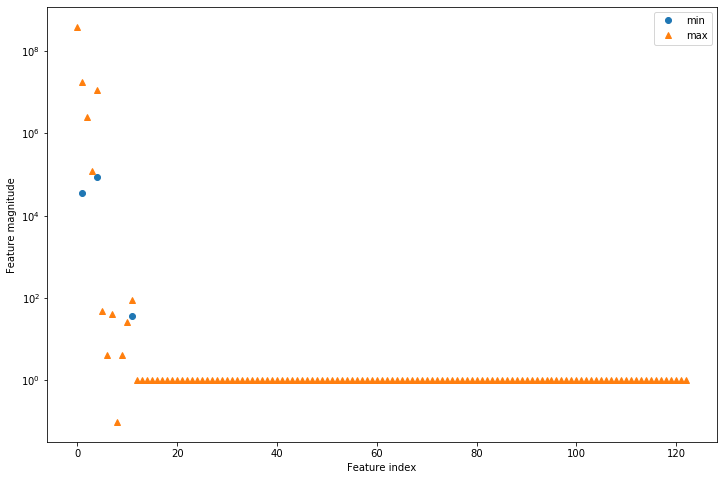

In [61]:
verifica_escala(variaveis_modelo,df)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[variaveis_modelo].values)
x=scaler.transform(df[variaveis_modelo].values)
df_scaled=pd.DataFrame(x,columns=variaveis_modelo)
df_scaled.head()
#df_original=df.copy()
df=df_scaled.copy()

MinMaxScaler()

,VL_BENS,VR_DESPESA_CONTRATADA,followers_count,tweets,VOTOS_TOTAL_PARL,REQ,PEC,PL,AUSENCIA,mandatos,...,SG_UE_SC,SG_UE_SE,SG_UE_SP,SG_UE_TO,MESA_Sim,LIDERANCA_Sim,debatedor,articulador,formulador,negociador
0,0.022278,0.482061,0.002561,0.049669,0.050903,0.395833,0.25,0.146341,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.003994,0.590963,0.567045,0.084516,1.000000,0.062500,0.25,0.073171,0.0,0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.007181,0.019148,0.053827,0.005454,0.067257,0.000000,0.00,0.073171,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.007485,0.158104,0.165492,1.000000,0.364455,0.000000,1.00,0.585366,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.003370,0.062998,1.000000,0.174101,0.417276,0.458333,0.00,0.170732,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
df.describe()

,VL_BENS,VR_DESPESA_CONTRATADA,followers_count,tweets,VOTOS_TOTAL_PARL,REQ,PEC,PL,AUSENCIA,mandatos,...,SG_UE_SC,SG_UE_SE,SG_UE_SP,SG_UE_TO,MESA_Sim,LIDERANCA_Sim,debatedor,articulador,formulador,negociador
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,...,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.032591,0.145440,0.051044,0.073947,0.145414,0.172971,0.233553,0.216303,0.075525,0.134868,...,0.039474,0.039474,0.039474,0.039474,0.144737,0.486842,0.078947,0.118421,0.118421,0.065789
std,0.133424,0.152908,0.148597,0.141185,0.177823,0.181526,0.268749,0.220408,0.161576,0.205916,...,0.196013,0.196013,0.196013,0.196013,0.354173,0.503148,0.271448,0.325253,0.325253,0.249561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001861,0.055525,0.002515,0.009814,0.034254,0.041667,0.000000,0.073171,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.004968,0.117729,0.006624,0.035014,0.075370,0.114583,0.250000,0.121951,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.011067,0.169740,0.032058,0.087157,0.190775,0.234375,0.250000,0.274390,0.098696,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualizando com PCA

In [64]:
x=df.values
variaveis=list(df.columns)

In [65]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model 
pca.fit(x)
# transform data onto the first two principal components
x_pca = pca.transform(x)
print("Original shape: {}".format(str(x.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))
df_pca=pd.DataFrame(x_pca,columns=["PC-1","PC-2","PC-3"])

PCA(n_components=3)

Original shape: (76, 123)
Reduced shape: (76, 3)


In [ ]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[:, 0], x_pca[:, 1])
#plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC-1'], df_pca['PC-2'], df_pca['PC-3'], c='skyblue', s=30)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("third principal component")
ax.view_init(20, -120)
plt.show()

In [ ]:
df_pca_componentes=pd.DataFrame(pca.components_, columns=variaveis)
print("PCA component shape: {}".format(df_pca_componentes.shape))
df_pca_componentes
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
#(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
def plot_pca_2d(x,y=True):
    plt.figure(figsize=(8, 8))
    if y.all():
        plt.scatter(x[:, 0], x[:, 1])
        plt.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            plt.scatter(x[row_ix, 0], x[row_ix, 1])
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.legend(clusters, loc="best")
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [ ]:
def plot_pca_3d(x,y=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y.all():
        ax.scatter(x[:, 0], x[:, 1],x[:,2])
        ax.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            ax.scatter(x[row_ix, 0], x[row_ix, 1],x[row_ix, 2], s=20)
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")
    ax.legend(clusters, loc='upper left')
    ax.view_init(35, -120)
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

## ajustando variáveis

In [ ]:
x=df.values

## K-mean


## Verificando o número de clusters via inércia

In [ ]:
kvalues=range(1,50)
kvalues
inercia=[]
for k in kvalues:
    modelo=KMeans(n_clusters=k, init='k-means++')
    modelo.fit(x)
    inercia.append(modelo.inertia_)
df_inercia=pd.DataFrame({"Inercia":inercia, "K":kvalues}) 
df_inercia.plot("K","Inercia", marker='o')

In [ ]:
# defining the kmeans function with initialization as k-means++
modelo = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(variaveis_modelo)


In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_kmeans=df_original.copy()
df_kmeans["cluster"]=yhat
df_kmeans.sample(5)

## Mean-shift


In [ ]:
from sklearn.cluster import MeanShift
modelo = MeanShift()
# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_mean_s=df_original.copy()
df_mean_s["cluster"]=yhat
df_mean_s.sample(5)

In [ ]:
## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
modelo = DBSCAN(eps=0.5, min_samples=3)

In [ ]:
modelo.fit(x)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_dbscan=df_original.copy()
df_dbscan["cluster"]=yhat
df_dbscan.sample(5)

## GMM

In [ ]:
from sklearn.mixture import GaussianMixture
modelo = GaussianMixture(n_components=6)
modelo.fit(x)
yhat = modelo.predict(x)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_GMM=df_original.copy()
df_GMM["cluster"]=yhat
df_GMM.sample(5)

## Aglomerative H Cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
modelo = AgglomerativeClustering(n_clusters=5)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
#df_HC=df_original.copy()
df_HC=df.copy()
df_HC["cluster"]=yhat
df_HC.sample(5)

## creating a distance matrix using linkage

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Use the linkage() function
distance_matrix = linkage(x,method = 'ward', metric = 'euclidean') # method = 'single'/'complete'

# Assign cluster labels
#comic_con['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')
dendrogram(distance_matrix)

In [ ]:
#dendrogram(distance_matrix)
# Use fcluster to extract labels: labels
clusters = fcluster(distance_matrix, 1.6, criterion='distance' )
df_ch=df_original.copy()
df_ch["cluster"]=clusters
df_ch.head(5)

# Avaliação com ARI Adjusted Rand Score Index

In [ ]:
# adjusted rand score is 1, as the clustering is exactly the same
# df_kmeans, df_mean_s, df_dbscan, df_GMM, df_HC, df_ch

In [ ]:
from sklearn.metrics import adjusted_rand_score
target=df_HC
lista=[df_kmeans,df_mean_s,df_dbscan,df_GMM,df_HC,df_ch]

for df in lista:
    print("ARI: {:.2f}".format(adjusted_rand_score(target["cluster"].values, df["cluster"].values)))


## EDA com K-mean

In [ ]:
df=df_HC.copy()

## EDA Básico

In [ ]:
df.info()
df.describe().round(2)

In [ ]:
#df.fillna(0, inplace=True)
#df.info()

In [ ]:
df.describe(include=np.object)

In [ ]:
df.info()
unicos=df.nunique()
unicos

## Defindo variaveis categóricas numericas

In [ ]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [ ]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
variaveis_categoricas= df.select_dtypes(include="category").columns
df[variaveis_numericas].info()
df[variaveis_categoricas].info()

In [ ]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].info()

### Histogramas

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


In [ ]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


In [ ]:
df.info()

In [ ]:
variaveis=list(variaveis_numericas)+list(variaveis_categoricas)
variaveis.remove("cluster")
preditores=variaveis
target=["cluster"]
variaveis=["cluster"]+variaveis
variaveis

In [ ]:

df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")

correlação=df[variaveis].corr()
correlação
plt.rc('figure', figsize=(12, 8))
sns.heatmap(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
sns.pairplot(df[variaveis], kind="scatter")

In [ ]:
sns.pairplot(df, y_vars=target, x_vars=preditores, hue=target[0])